# 1. Make Data Loader with `torchvision`

In [2]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader,random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter 

## 1.1 Make dataloader with `transform` and `ImageFolder`

In [3]:
# Define data transformations (adjust as needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:

# Create a dataset using torchvision's ImageFolder
dataset = datasets.ImageFolder(root='./PetImages/',transform=transform)

# Split dataset into training and testing
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create a DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


len(train_loader),len(test_loader)

(625, 157)

In [4]:
for batch_idx,(data,labels) in enumerate(train_loader):
    loader_index=batch_idx
    print(f"Batch {loader_index + 1}: Data shape - {data.shape}, Labels shape - {labels.shape}")

Batch 1: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 2: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 3: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 4: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 5: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 6: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 7: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 8: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 9: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 10: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])


c:\Users\DELL\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Batch 11: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 12: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 13: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 14: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 15: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 16: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 17: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 18: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 19: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 20: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 21: Data shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 22: Data shape - torch.Size([32, 3, 224, 224]), 

## 1.2 Visualization for exact image

In [4]:
train_features_batch,train_labels_batch=next(iter(test_loader))

In [5]:
def visualization(dataloader:DataLoader,img_index:int):
        
    data_features_batch,data_labels_batch=next(iter(dataloader))
    img=data_features_batch[img_index]
    label=data_labels_batch[img_index]
    if label==1:
        label='Dog'
    else:
        label='Cat'
    plt.imshow(img.permute(1,2,0).squeeze(),cmap='gray')
    plt.title(f"Label:{label}")

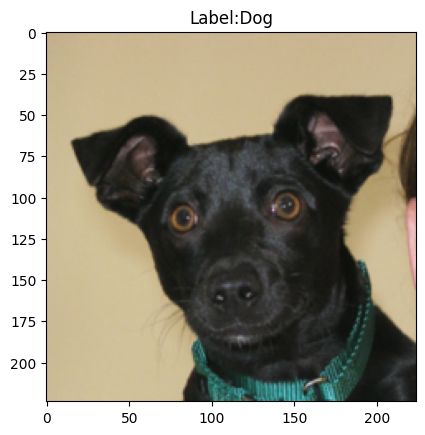

In [6]:
visualization(train_loader,4)

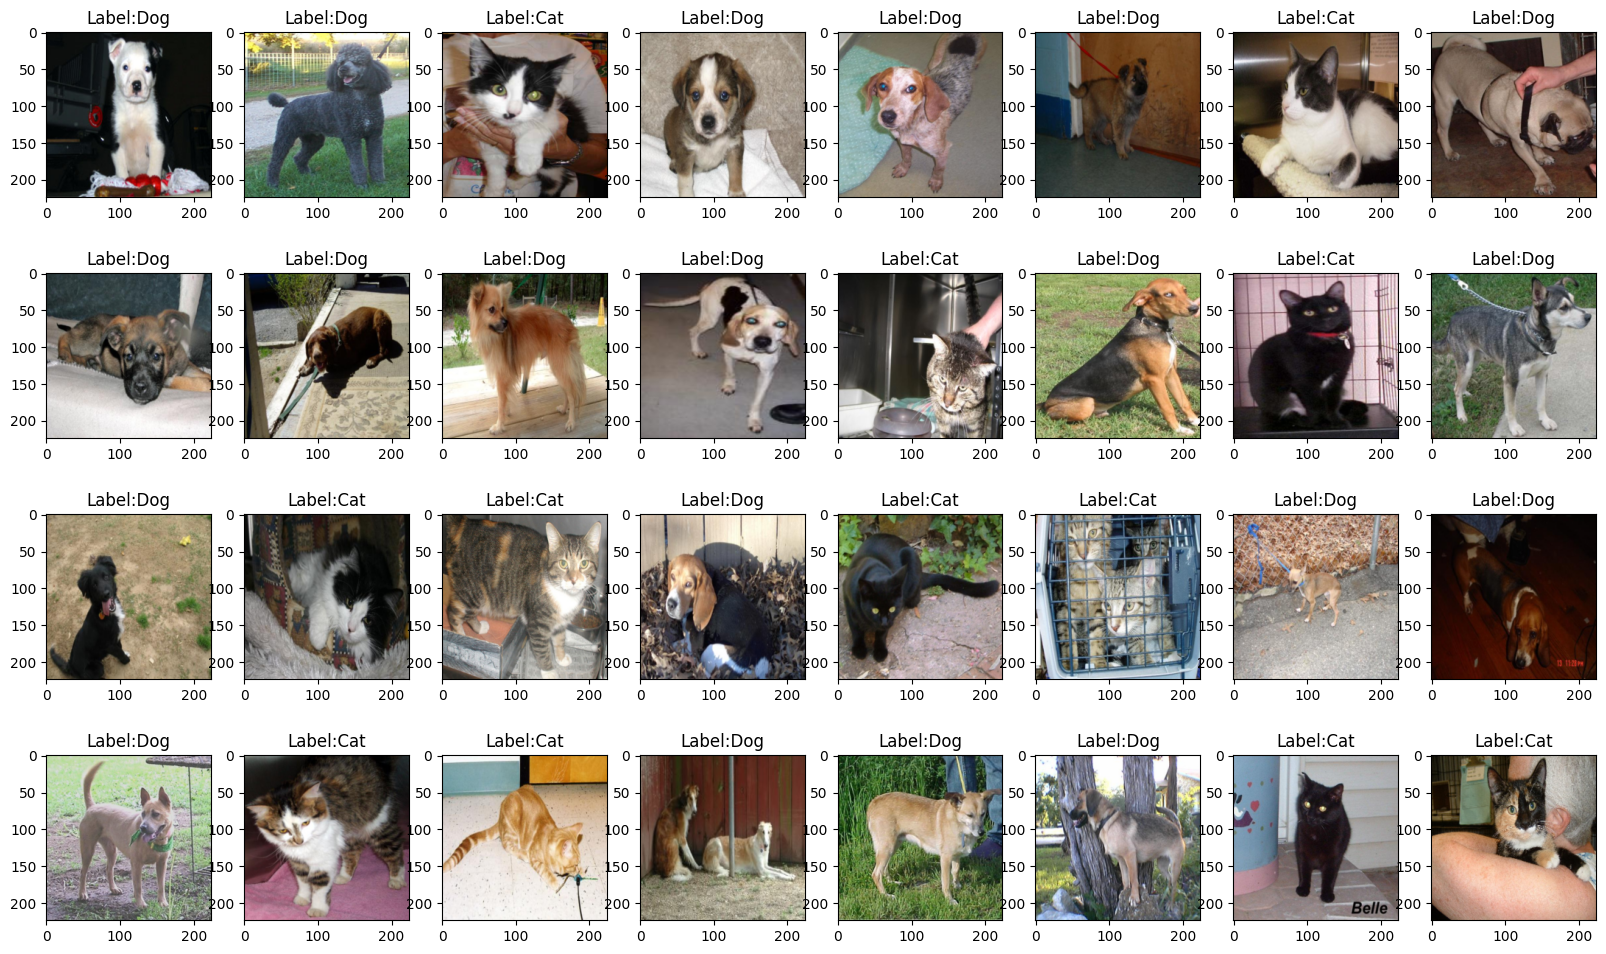

In [7]:
plt.figure(figsize=(20,12))
rows=4
cols=8
for i in range(len(train_features_batch)):
    plt.subplot(rows,cols,i+1)
    visualization(train_loader,i)

# 2. Model

## 2.1 Model within `Linear()` only

In [166]:
class Model0_CAD(nn.Module):
    def __init__(self,
                 input_shape:int,
                 output_shape:int,
                 hidden_units:int,):
        super().__init__()
        self.layer_stack=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
        )
    def forward(self,x):
        return self.layer_stack(x)

In [167]:
model_0=Model0_CAD(224*224*3,2,10)

### 2.1.1 Loss function and optimizer

In [168]:
loss_0_fn=nn.CrossEntropyLoss()
optimizer_0=optim.SGD(model_0.parameters(),lr=0.01)

### 2.1.2 Define a function for accuracy

In [13]:
def accuracy_fn(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc=(correct/len(y_pred))*100
    return acc

### 2.1.3 Define a function for eval

In [14]:
def eval_model(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):
    loss,acc=0,0
    model.eval()
    with torch.inference_mode():
        for x,y in data_loader:
            y_pred=model(x)

            loss+=loss_fn(y_pred,y)
            acc+=accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))
        loss/=len(data_loader)
        acc/=len(data_loader)
    return {"model_name":model.__class__.__name__,
            "model_loss":loss.item(),
            "model_acc":acc}

In [172]:
torch.manual_seed(42)

epochs=5

train_loss=0

train_acc=0

for epoch in tqdm(range(epochs)):
    for batch,(x,y) in enumerate(train_loader):

        model_0.train()

        y_pred_0=model_0(x)

        loss=loss_0_fn(y_pred_0,y)

        acc=accuracy_fn(y,y_pred_0.argmax(dim=1))

        train_loss+=loss

        train_acc+=acc

        optimizer_0.zero_grad()

        loss.backward()

        optimizer_0.step()

        if batch % 200==0:
            print(f"Looked at {batch*len(x)}/{len(train_loader.dataset)} samples")

    train_loss/=len(train_loader)

    train_acc/=len(train_loader)

    test_loss,test_acc=0,0

    model_0.eval()

    with torch.inference_mode():
        for x_test,y_test in test_loader:

            test_pred_0=model_0(x_test)

            test_loss+=loss_0_fn(test_pred_0,y_test)

            test_acc+=accuracy_fn(y_test,test_pred_0.argmax(dim=1))

        test_loss/=len(test_loader)

        test_acc/=len(test_loader)
    print(f"\nTrain loss:{train_loss:4f} | Test loss:{test_loss:4f} | Train acc:{train_acc:4f} | Test acc{test_acc:4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Looked at 0/19998 samples
Looked at 6400/19998 samples
Looked at 12800/19998 samples
Looked at 19200/19998 samples


 20%|██        | 1/5 [00:57<03:50, 57.60s/it]


Train loss:0.670389 | Test loss:0.671739 | Train acc:58.747000 | Test acc58.678344
Looked at 0/19998 samples
Looked at 6400/19998 samples
Looked at 12800/19998 samples
Looked at 19200/19998 samples


 40%|████      | 2/5 [01:56<02:54, 58.17s/it]


Train loss:0.667577 | Test loss:0.665331 | Train acc:59.770329 | Test acc58.957006
Looked at 0/19998 samples
Looked at 6400/19998 samples
Looked at 12800/19998 samples
Looked at 19200/19998 samples


 60%|██████    | 3/5 [02:55<01:57, 58.56s/it]


Train loss:0.668112 | Test loss:0.668482 | Train acc:59.670966 | Test acc58.996815
Looked at 0/19998 samples
Looked at 6400/19998 samples
Looked at 12800/19998 samples
Looked at 19200/19998 samples


 80%|████████  | 4/5 [03:52<00:58, 58.18s/it]


Train loss:0.664385 | Test loss:0.671111 | Train acc:59.932474 | Test acc59.474522
Looked at 0/19998 samples
Looked at 6400/19998 samples
Looked at 12800/19998 samples
Looked at 19200/19998 samples


100%|██████████| 5/5 [04:50<00:00, 58.14s/it]


Train loss:0.661324 | Test loss:0.667118 | Train acc:60.920892 | Test acc58.519108


### 2.1.4 Add a graph with `TensorBoard`

In [180]:
writer_0=SummaryWriter()
writer_0.add_graph(model_0,torch.randn([1,3,224,224]))

In [3]:
! tensorboard --logdir=runs

^C


In [173]:
print(model_0)

Model0_CAD(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)


## Change size of data for model

In [185]:
train_features_batch[0].view(1,3,224,224).shape

torch.Size([1, 3, 224, 224])

In [186]:
label_pred=model_0(train_features_batch[0].view(1,3,224,224))

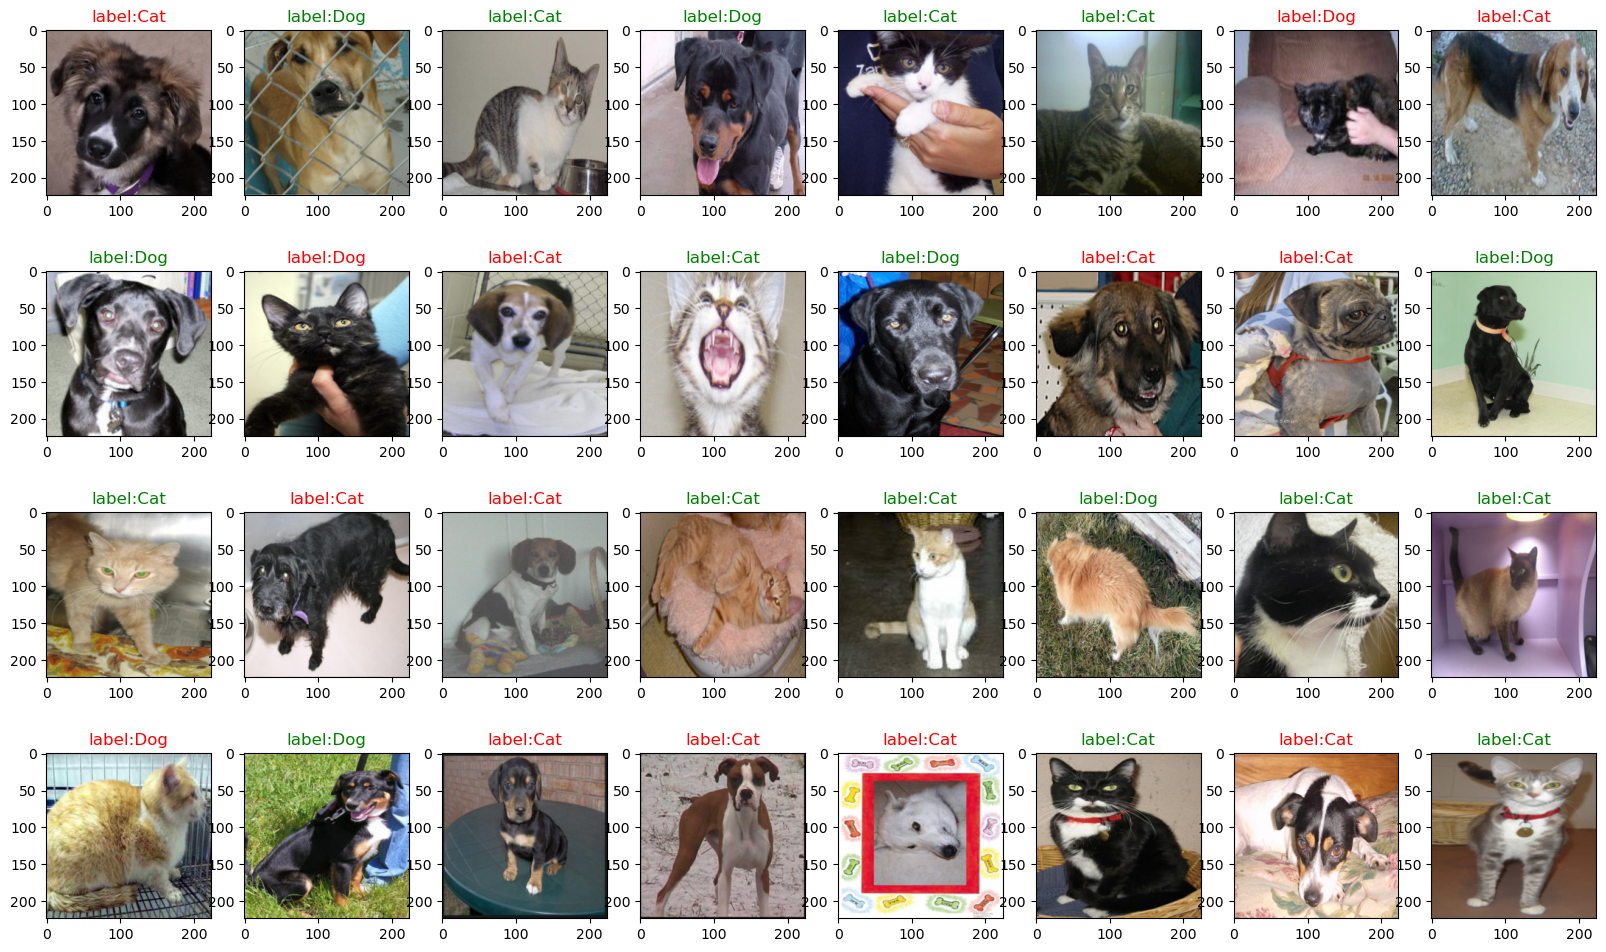

In [233]:
plt.figure(figsize=(20,12))
rows=4
cols=8
for i in range(len(train_features_batch)):
    plt.subplot(rows,cols,i+1)
    # Adjust dim of tensor for model prediction
    train_features_batch_m=train_features_batch[i].view(1,3,224,224)

    label_pred=model_0(train_features_batch_m).argmax(dim=1)
    if label_pred==0:
            label="Cat"
    else:
            label="Dog" 

    if label_pred==train_labels_batch[i]:
        plt.imshow(train_features_batch[i].permute(1,2,0))
        plt.title(f"label:{label}",color='green')
    else:
        plt.imshow(train_features_batch[i].permute(1,2,0))
        plt.title(f"label:{label}",color='red')

## 2.2 Model within `Linear()` and `ReLU()`

In [195]:
class Model1_CAD(nn.Module):
    def __init__(self,
                 input_shape:int,
                 output_shape:int,
                 hidden_units:int):
        super().__init__()
        self.layer_stack=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
            nn.ReLU()
        )

    def forward(self,x):
        return self.layer_stack(x)

In [196]:
model_1=Model1_CAD(224*224*3,2,10)

In [197]:
loss_1_fn=nn.CrossEntropyLoss()
optimizer_1=optim.SGD(model_1.parameters(),lr=0.01)

In [198]:
torch.manual_seed(42)

epochs=10

train_loss,train_acc=0,0

for epoch in tqdm(range(epochs)):
    for batch,(x,y) in enumerate(train_loader):
        model_1.train()

        y_pred=model_1(x)

        loss=loss_1_fn(y_pred,y)

        acc=accuracy_fn(y,y_pred.argmax(dim=1))

        train_loss+=loss

        train_acc+=acc

        optimizer_1.zero_grad()

        loss.backward()

        optimizer_1.step()

        if batch % 200==0:
            print(f"Looked at {batch*len(x)}/{len(train_loader.dataset)} samples")

    train_loss/=len(train_loader)

    train_acc/=len(train_loader)

    test_loss,test_acc=0,0

    model_1.eval()

    with torch.inference_mode():
        for x_test,y_test in test_loader:

            test_pred_1=model_1(x_test)

            test_loss+=loss_1_fn(test_pred_1,y_test)

            test_acc+=accuracy_fn(y_test,test_pred_1.argmax(dim=1))

        test_loss/=len(test_loader)

        test_acc/=len(test_loader)
        
    print(f"\nTrain Loss:{train_loss:4f} | Test Loss:{test_loss:4f} | Train acc{train_acc:4f} | Test acc{test_acc:4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Looked at 0/19998 samples
Looked at 6400/19998 samples


/Users/chensmac/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Looked at 12800/19998 samples
Looked at 19200/19998 samples


 10%|█         | 1/10 [00:58<08:47, 58.65s/it]


Train Loss:0.694099 | Test Loss:0.693156 | Train acc50.004000 | Test acc49.980096
Looked at 0/19998 samples
Looked at 6400/19998 samples
Looked at 12800/19998 samples
Looked at 19200/19998 samples


 20%|██        | 2/10 [02:00<08:02, 60.37s/it]


Train Loss:0.694318 | Test Loss:0.693155 | Train acc50.010006 | Test acc49.920382
Looked at 0/19998 samples
Looked at 6400/19998 samples
Looked at 12800/19998 samples
Looked at 19200/19998 samples


 30%|███       | 3/10 [03:03<07:12, 61.85s/it]


Train Loss:0.694333 | Test Loss:0.693156 | Train acc49.899349 | Test acc49.980096
Looked at 0/19998 samples
Looked at 6400/19998 samples
Looked at 12800/19998 samples
Looked at 19200/19998 samples


 40%|████      | 4/10 [04:06<06:12, 62.05s/it]


Train Loss:0.694331 | Test Loss:0.693147 | Train acc49.669172 | Test acc49.920382
Looked at 0/19998 samples
Looked at 6400/19998 samples
Looked at 12800/19998 samples
Looked at 19200/19998 samples


 50%|█████     | 5/10 [05:05<05:05, 61.11s/it]


Train Loss:0.694318 | Test Loss:0.693155 | Train acc49.748471 | Test acc49.960191
Looked at 0/19998 samples
Looked at 6400/19998 samples
Looked at 12800/19998 samples
Looked at 19200/19998 samples


 60%|██████    | 6/10 [06:11<04:11, 62.89s/it]


Train Loss:0.694316 | Test Loss:0.693175 | Train acc49.808598 | Test acc49.920382
Looked at 0/19998 samples
Looked at 6400/19998 samples
Looked at 12800/19998 samples
Looked at 19200/19998 samples


 70%|███████   | 7/10 [07:14<03:08, 62.71s/it]


Train Loss:0.694311 | Test Loss:0.693159 | Train acc49.999027 | Test acc49.980096
Looked at 0/19998 samples
Looked at 6400/19998 samples
Looked at 12800/19998 samples
Looked at 19200/19998 samples


 80%|████████  | 8/10 [08:17<02:05, 62.90s/it]


Train Loss:0.694332 | Test Loss:0.693144 | Train acc49.490665 | Test acc50.199045
Looked at 0/19998 samples
Looked at 6400/19998 samples
Looked at 12800/19998 samples
Looked at 19200/19998 samples


 90%|█████████ | 9/10 [09:22<01:03, 63.62s/it]


Train Loss:0.694273 | Test Loss:0.693177 | Train acc50.248185 | Test acc50.159236
Looked at 0/19998 samples
Looked at 6400/19998 samples
Looked at 12800/19998 samples
Looked at 19200/19998 samples


100%|██████████| 10/10 [10:26<00:00, 62.70s/it]


Train Loss:0.694278 | Test Loss:0.693184 | Train acc50.209064 | Test acc50.019904


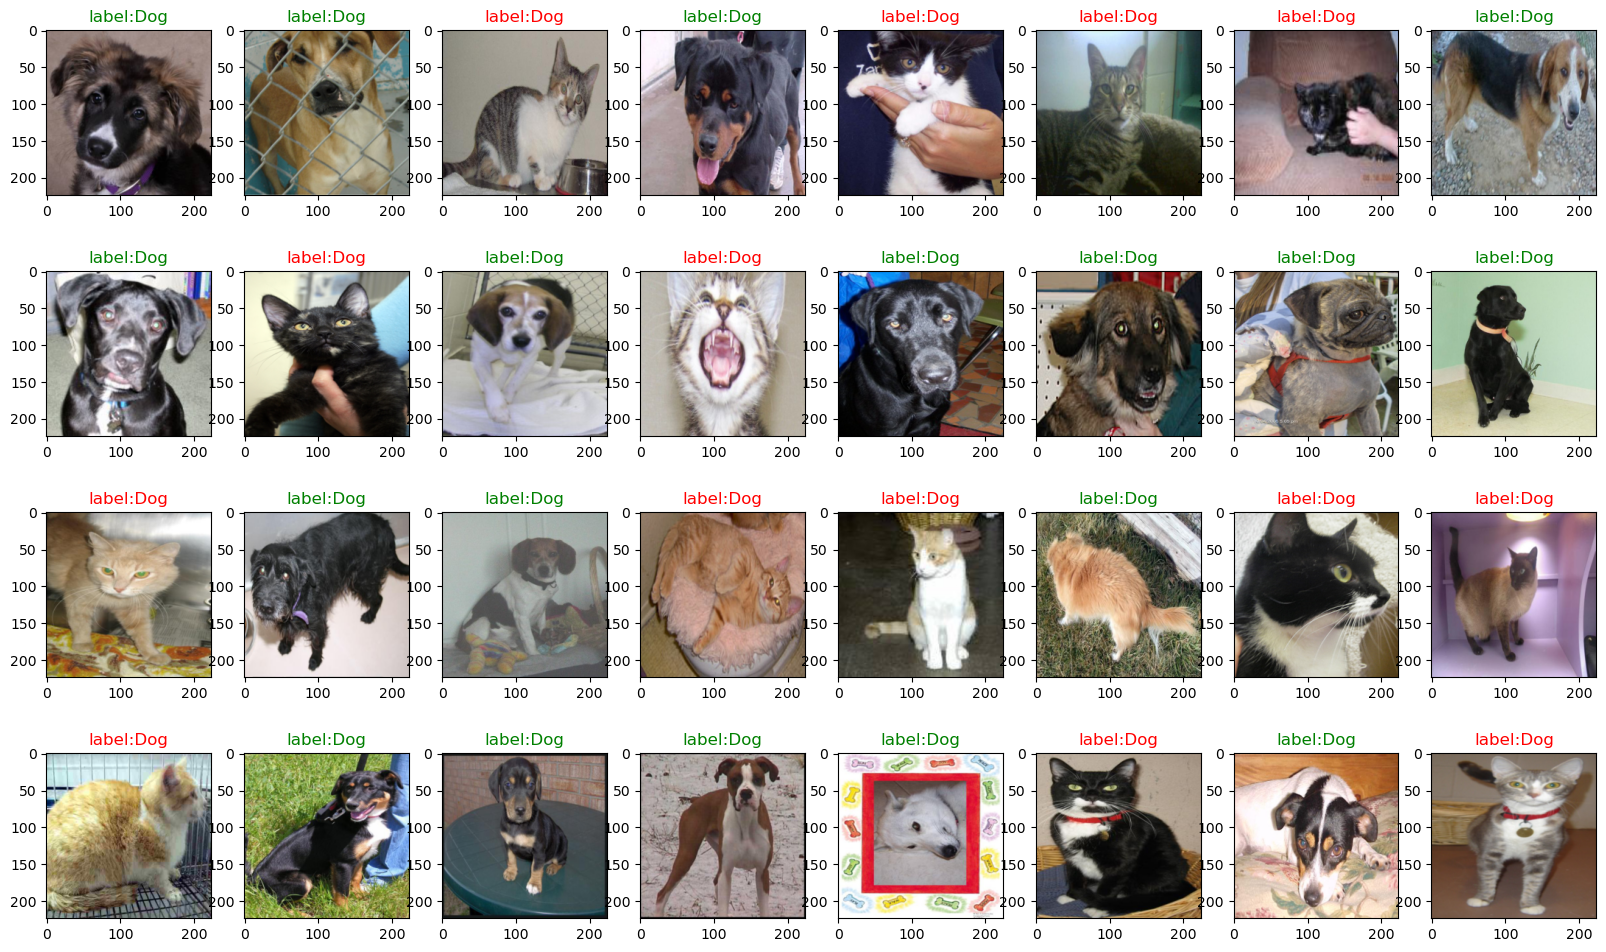

In [234]:
plt.figure(figsize=(20,12))
rows=4
cols=8
for i in range(len(train_features_batch)):
    plt.subplot(rows,cols,i+1)
    # Adjust dim of tensor for model prediction
    train_features_batch_m=train_features_batch[i].view(1,3,224,224)

    label_pred=model_1(train_features_batch_m).argmax(dim=1)
    if label_pred==0:
            label="Cat"
    else:
            label="Dog" 

    if label_pred==train_labels_batch[i]:
        plt.imshow(train_features_batch[i].permute(1,2,0))
        plt.title(f"label:{label}",color='green')
    else:
        plt.imshow(train_features_batch[i].permute(1,2,0))
        plt.title(f"label:{label}",color='red')

## 2.3 Model within `Conv2d()`,`MaxPool2d()` and `Linear()`

In [5]:
class Model2_MNIST(nn.Module):
    def __init__(self,
                 input_shape:int,
                 output_shape:int,
                 hidden_shape:int):
        super().__init__()
        self.block1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_shape,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_shape,
                      out_channels=hidden_shape,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.block2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_shape,
                      out_channels=hidden_shape,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_shape,
                      out_channels=hidden_shape,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            #Flattten data into 1x31360
            nn.Linear(in_features=hidden_shape*56*56,out_features=output_shape)
        )
    
    def forward(self,x):
        x=self.block1(x)
        x=self.block2(x)
        x=self.classifier(x)

        return x

In [7]:
model_2=Model2_MNIST(input_shape=3,hidden_shape=10,output_shape=2)

In [8]:
loss_2_fn=nn.CrossEntropyLoss()
optimizer_2=optim.SGD(model_2.parameters(),lr=0.01)

### 2.3.1 Train with `cuda`

In [11]:
device=torch.device('cuda')
model_2=model_2.to(device)


In [19]:
torch.manual_seed(42)

epochs=5

train_loss=0

train_acc=0

test_loss=0

test_acc=0

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n--------")
    
    for batch,(x,y) in enumerate(train_loader):
        x,y=x.to(device),y.to(device)
        model_2.train()

        y_pred=model_2(x)

        loss=loss_2_fn(y_pred,y)

        acc=accuracy_fn(y,y_pred.argmax(dim=1))

        train_loss+=loss

        train_acc+=acc

        optimizer_2.zero_grad()

        loss.backward()

        optimizer_2.step()
    
    train_loss/=len(train_loader)

    train_acc/=len(train_loader)

    print(f"Training loss:{train_loss:5f} | Train acc:{train_acc:2f}")



    model_2.eval()

    with torch.inference_mode():
        for x_test,y_test in test_loader:
            x_test,y_test=x_test.to(device),y_test.to(device)
            
            test_pred_2=model_2(x_test)

            test_loss+=loss_2_fn(test_pred_2,y_test)

            test_acc+=accuracy_fn(y_test,test_pred_2.argmax(dim=1))
        
        test_loss/=len(test_loader)

        test_acc/=len(test_loader)

    print(f"\nTest loss:{test_loss:4f} | Test acc{test_acc:4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0
--------
Training loss:0.283853 | Train acc:87.739000

Test loss:0.736551 | Test acc70.839968
Epoch 1
--------
Training loss:0.267409 | Train acc:88.424382

Test loss:0.763834 | Test acc70.992611
Epoch 2
--------
Training loss:0.252388 | Train acc:89.634812

Test loss:0.787270 | Test acc70.894061
Epoch 3
--------
Training loss:0.234548 | Train acc:90.381416

Test loss:0.825541 | Test acc71.868752
Epoch 4
--------
Training loss:0.222595 | Train acc:90.869610

Test loss:0.894416 | Test acc71.019068


In [20]:
model_2=model_2.to('cpu')

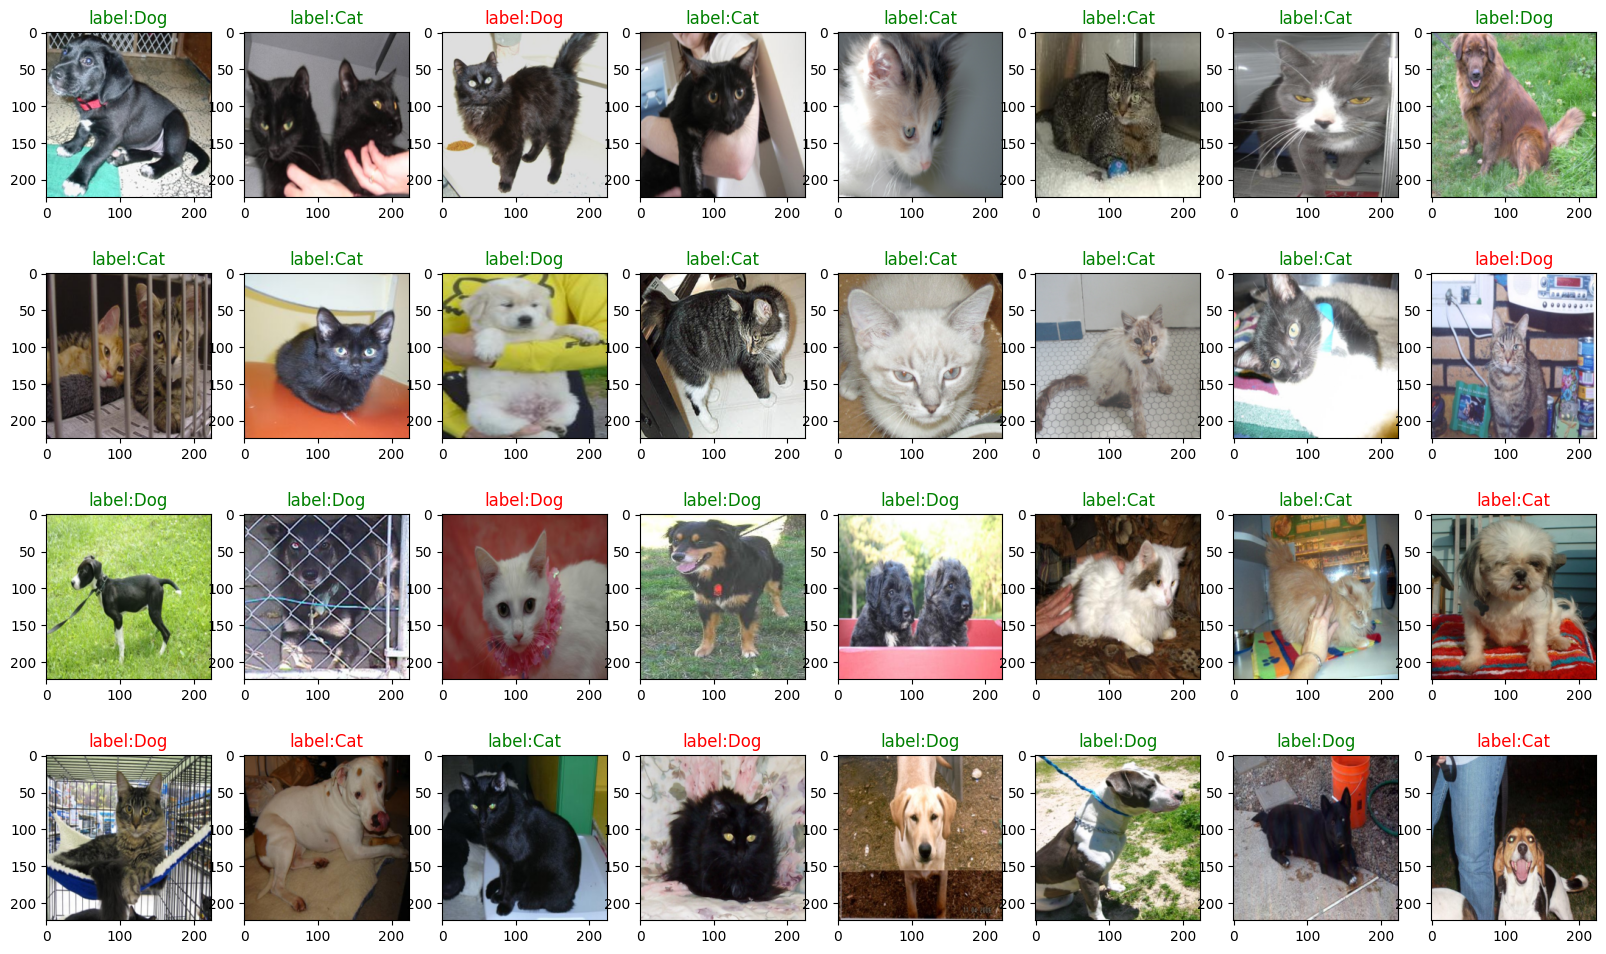

In [21]:
plt.figure(figsize=(20,12))
rows=4
cols=8
for i in range(len(train_features_batch)):
    plt.subplot(rows,cols,i+1)
    # Adjust dim of tensor for model prediction
    train_features_batch_m=train_features_batch[i].view(1,3,224,224)

    label_pred=model_2(train_features_batch_m).argmax(dim=1)
    if label_pred==0:
            label="Cat"
    else:
            label="Dog" 

    if label_pred==train_labels_batch[i]:
        plt.imshow(train_features_batch[i].permute(1,2,0))
        plt.title(f"label:{label}",color='green')
    else:
        plt.imshow(train_features_batch[i].permute(1,2,0))
        plt.title(f"label:{label}",color='red')

## 2.4 Saving Model

In [22]:
torch.save(model_2,'Model2_CatDog.pth')

In [23]:
torch.save(model_2.state_dict(),'Model2_CatDog_dict.pth')